# Simple spheres data processing 

### Setup

#### Ensuring Reproducibility with Seeds

In this code, a seed value (`seed_value=42`) is set to maintain consistency and reproducibility across multiple runs. This fixed seed is used for all random number generators (in Python, NumPy, and TensorFlow). By doing so, it is ensured that the pseudo-random sequences generated during model training are identical across runs, which is crucial for comparison and debugging purposes.


In [12]:
seed_value=42
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import tensorflow as tf
tf.random.set_seed(seed_value)


In [13]:
import pandas as pd
import matplotlib.pyplot as plt

import plotly.graph_objs as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Normalization, Input, Activation, Dropout
from tensorflow.keras import layers, optimizers
from tensorflow.keras import callbacks
import keras_tuner as kt

In [14]:
plt.rcParams.update({
   "font.family": "serif",  # use serif/main font for text elements
   "text.usetex": True,     # use inline math for ticks
   "pgf.rcfonts": False     # don't setup fonts from rc parameters
   })

# Read and display data

In [54]:
df1=pd.read_csv(r'spheres_dataset.csv')
df1

,radius,refractive index,Ext. maxima,wavelgth ext. max.,Sca. maxima,wavelgth sca. max.,Abs. maxima,wavelgth abs. max.,EF. maxima,wavelgth ef. max.
0,20.0,1.00,1.280937,516.0,0.043212,522.0,1.241792,514.0,1.018941,508.0
1,20.0,1.05,1.546413,520.0,0.057436,522.0,1.490329,518.0,1.026474,418.0
2,20.0,1.10,1.853285,520.0,0.075461,526.0,1.779933,520.0,1.033442,520.0
3,20.0,1.15,2.174521,520.0,0.098606,532.0,2.081695,520.0,1.039943,526.0
4,20.0,1.20,2.506169,522.0,0.128139,536.0,2.387432,522.0,1.046219,534.0
...,...,...,...,...,...,...,...,...,...,...
436,100.0,1.80,5.710937,696.0,4.361668,694.0,1.596705,614.0,2.843320,700.0
437,100.0,1.85,5.667940,708.0,4.351912,706.0,1.598348,624.0,2.774940,714.0
438,100.0,1.90,5.620068,760.0,4.315172,718.0,1.623708,666.0,2.685431,726.0
439,100.0,1.95,5.587177,776.0,4.280363,732.0,1.651854,676.0,2.602430,740.0


In [16]:
WlExtMax=df1['wavelgth ext. max.']
WlAbsMax=df1['wavelgth abs. max.']
WlScaMax=df1['wavelgth sca. max.']
WlEFMax=df1['wavelgth ef. max.']

ExtCoefMax=df1['Ext. maxima']
AbsCoefMax=df1['Abs. maxima']
ScaCoefMax=df1['Sca. maxima']
EFCoefMax=df1['EF. maxima']

r=df1['radius']
ni=df1['refractive index']

Data is put into matrix form to facilitate processing

In [17]:
nr=len(np.unique(r))
nni=len(np.unique(ni))
R=np.reshape(np.array(r),(nr,nni))
WEXTM=np.reshape(np.array(WlExtMax),(nr,nni))
WABSM=np.reshape(np.array(WlAbsMax),(nr,nni))
WSCAM=np.reshape(np.array(WlScaMax),(nr,nni))
WEFM=np.reshape(np.array(WlEFMax),(nr,nni))

### Repartition of the data

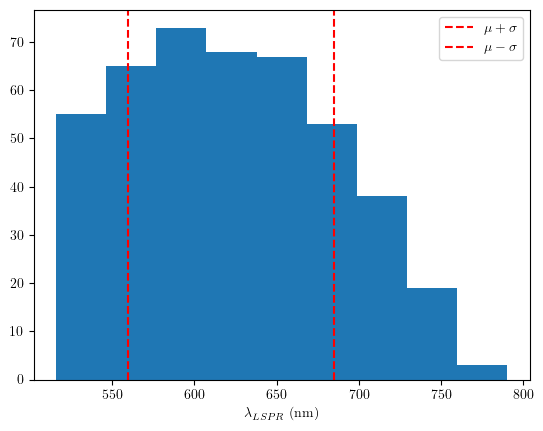

In [18]:
plt.figure()
plt.hist(WlExtMax,bins=9)
plt.xlabel('$\lambda_{LSPR}$ (nm)')

std1,std2=WlExtMax.mean()+WlExtMax.std(),WlExtMax.mean()-WlExtMax.std()

plt.axvline(x=std1,color='r',linestyle='--',label='$\mu+\sigma$')
plt.axvline(x=std2,color='r',linestyle='--',label='$\mu-\sigma$')
plt.legend()

plt.show()



### Displaying the data: Behavior of the spectra with change in the radius

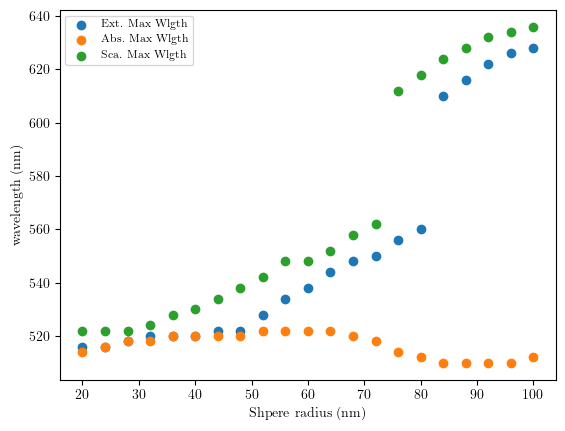

In [19]:
plt.figure()
plt.scatter(R[:,0],WEXTM[:,0],label='Ext. Max Wlgth ')
plt.scatter(R[:,0],WABSM[:,0],label='Abs. Max Wlgth ')
plt.scatter(R[:,0],WSCAM[:,0],label='Sca. Max Wlgth ')
plt.ylabel("wavelength (nm)")
plt.xlabel("Shpere radius (nm)")
plt.legend(loc='best', fontsize=8)
plt.show()

## First model with linear regression

Only the radius and the LSPR peak are used

Defining labels and features

In [20]:
label=WEXTM[:-5,0]
feature=R[:-5,0]
feature_train, feature_test, label_train, label_test = train_test_split(feature, label, test_size=0.1,random_state=seed_value)

### Parametring the model

The next function is only used for hyperparameter tuning

In [12]:
def build_model(hp):

    """
    This function builds a simple Sequential model with one dense layer.
    The learning rate for the model's optimizer is determined by a hyperparameter search space.

    Arguments:
    hp -- Keras Tuner hyperparameters class instance, used for defining the learning rate range

    Returns:
    The constructed Sequential model with defined optimizer, loss function and learning rate.
    """

    learning_rate = hp.Float("learning_rate", min_value=0.1, max_value=100,sampling="log") #the learning rate is the only hyperparameter in this case

    model=Sequential() 
    model.add(Normalization(input_shape=[1]))
    model.add(Dense(units=1, input_shape=[1])) #add a layer with one neurone and one input
    model.compile(optimizer=optimizers.Adam(learning_rate), loss='mean_squared_error') #Adam is the optimisation algorithm used (gradient descent type)
    return model

#### Bayesian Hyperparameter Tuning

This code uses Bayesian Optimization via Keras Tuner (`kt.BayesianOptimization`) for hyperparameter tuning. The goal is to find the optimal model hyperparameters that minimize the 'loss'. It performs a search over a specified range of hyperparameters (defined in `build_model` function), evaluating 25 different configurations (`max_trials=25`). 

The best hyperparameters are then retrieved and displayed. This process improves model performance by finding the most effective hyperparameters for this specific dataset and model.


In [13]:
bayesian_tuner = kt.BayesianOptimization(build_model, objective='loss', max_trials=25,directory="hpLinReg", project_name="my_bayesian_search")
bayesian_tuner.search(feature, label, epochs=1000, verbose=False)

lr = bayesian_tuner.get_best_hyperparameters()[0].values
lr

INFO:tensorflow:Reloading Tuner from hpLinReg/my_bayesian_search/tuner0.json
INFO:tensorflow:Oracle triggered exit


{'learning_rate': 16.86188018274204}

#### Training of the model

Upon a quick review of the data, one might assume that a simple linear regression would suffice to model the data. Conceptually, a linear regression can be viewed as a multilayer perceptron with a single layer consisting of one neuron that uses a linear activation function. This serves as a good starting point for utilizing neural networks.

In [21]:
linear_reg_model=Sequential() 
linear_reg_model.add(Normalization(input_shape=[1]))
linear_reg_model.add(Dense(units=1,kernel_initializer=tf.keras.initializers.HeNormal(seed=seed_value))) #add a layer with one neurone and one input
linear_reg_model.summary()
linear_reg_model.compile(optimizer=optimizers.Adam(16), loss='mean_squared_error') #Adam is the optimisation algorithm used (gradient descent type)

early_stopping_cb = callbacks.EarlyStopping(monitor='loss',patience=400,restore_best_weights=True)
history=linear_reg_model.fit(feature, label, epochs=1000,verbose=False,callbacks=early_stopping_cb,shuffle=False,use_multiprocessing=False)
weights, biases = linear_reg_model.layers[1].get_weights()
weights, biases,early_stopping_cb.stopped_epoch

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_3 (Dense)             (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


(array([[0.7661741]], dtype=float32), array([493.6913], dtype=float32), 812)

### Display the regression model evaluation

1/1 [==============================] - 0s 24ms/step


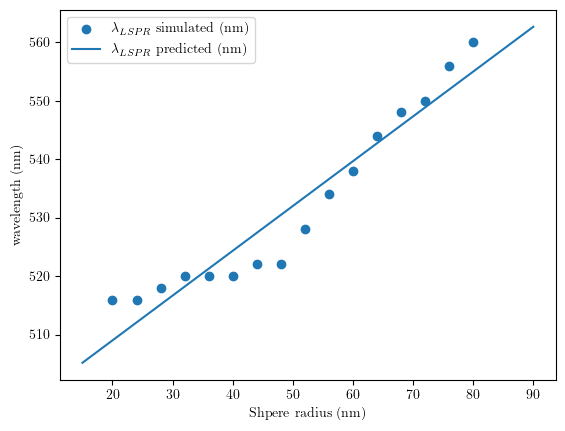

1/1 [==============================] - 0s 11ms/step
RMSE : 5.66407866377004 nm MAE : 5.4528656005859375 nm


In [22]:
nru=21
ru=np.linspace(15,90,nru).reshape(-1, 1)
nniu=21
niu=np.linspace(0.9,2.1,nniu).reshape(-1, 1)

LinRegEXT=linear_reg_model.predict(ru)
plt.figure()
plt.scatter(feature,label,label='$\lambda_{LSPR}$ simulated (nm)')
plt.plot(ru,LinRegEXT,label='$\lambda_{LSPR}$ predicted (nm)')
plt.ylabel("wavelength (nm)")
plt.xlabel("Shpere radius (nm)")
plt.legend(loc='best')
plt.show()

mse_linreg=linear_reg_model.evaluate(feature_test,label_test)
rmse_linreg=np.sqrt(mse_linreg)
mae_linreg=mean_absolute_error(label_test,linear_reg_model.predict(feature_test.reshape(-1, 1)))
print('RMSE :',rmse_linreg,'nm','MAE :',mae_linreg,'nm')

### Learning process through epochs

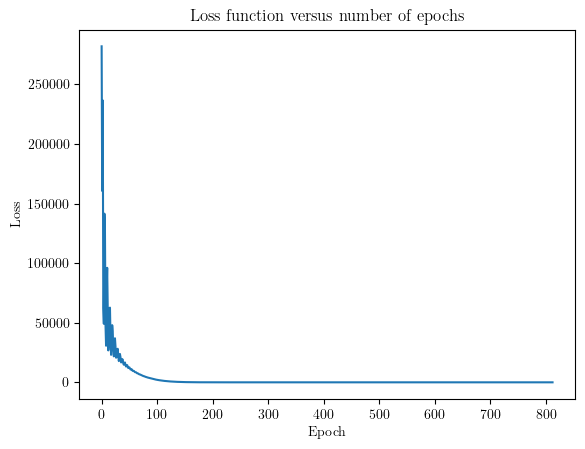

In [16]:
plt.plot(history.history['loss'])
plt.title('Loss function versus number of epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()


## New model with rectified linear unit

The data is not entirely linear. To accommodate this, one simple approach is to add a neuron and utilize a non-linear activation function. The Rectified Linear Unit (ReLU) is a straightforward non-linear function, which is set to zero for negative values and linear for positive values.

### Parametring the model

In [370]:
def build_modelMLP1(hp):
    """
    This function builds a simple Sequential multi-layer perceptron (MLP) model with two dense layers.
    The learning rate for the model's optimizer is determined by a hyperparameter search space.

    Arguments:
    hp -- Keras Tuner hyperparameters class instance, used for defining the learning rate range

    Returns:
    The constructed Sequential MLP model with defined optimizer, loss function, learning rate, and weight initialization.
    """
    initial_learning_rate = hp.Float("initial_learning_rate", min_value=1e-6, max_value=1e-1,sampling="log")
    decay_steps=hp.Int("decay_steps", min_value=1e1, max_value=1e6,sampling="log")
    decay_rate=hp.Float("decay_rate", min_value=1e-2, max_value=1,sampling="log")
    dropout_rate=hp.Float("dropout_rate", min_value=0.0, max_value=0.9)

    lr_schedule = optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=decay_steps,
        decay_rate=decay_rate)

    model=Sequential() 
    model.add(Normalization(input_shape=[1]))
    model.add(Dense(units=2,activation='relu',kernel_initializer="he_normal"))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1))
    model.compile(optimizer=optimizers.Adam(lr_schedule), loss='mean_squared_error')
    return model


Training of the model

In [371]:
random_search_tuner = kt.BayesianOptimization(build_modelMLP1, objective='loss', max_trials=50,overwrite=True,directory="hpMLP1", project_name="my_bayesian_search")
random_search_tuner.search(feature, label, epochs=10000,verbose=False)
random_search_tuner.get_best_hyperparameters()[0].values

/Users/eliasabboubi/opt/miniconda3/envs/prelab-01/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/eliasabboubi/opt/miniconda3/envs/prelab-01/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/eliasabboubi/opt/miniconda3/envs/prelab-01/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.w

INFO:tensorflow:Oracle triggered exit


{'initial_learning_rate': 0.06043386658518334,
 'decay_steps': 4337,
 'decay_rate': 0.2793605573059934,
 'dropout_rate': 0.19125416321247918}

#### Addition of Dropout Layer

It was found that local minima were reached during the training process. Here are the strategies used to overcome this issue.

A `Dropout` layer is included to the model to prevent the training process from getting stuck in local minima. This layer randomly nullifies 10% of the input units at each update during training, introducing a form of noise and randomness to the process. 

The rationale is that the noise from Dropout can push the model out of local minima during training, leading the optimization process towards different regions of the parameter space. Consequently, this helps in finding a solution closer to the global minimum, improving the generalization of our model.


#### Learning Rate Scheduling

In this model, we use a learning rate schedule to adapt the learning rate during training. The schedule is defined by an `ExponentialDecay` function, which decreases the learning rate exponentially after a certain number of steps.

The initial learning rate is set at `5e-2`, and decay to `2e-2`. 

Using this learning rate schedule, the model can learn quickly at the start of the training process when set to a higher initial learning rate, and then refine the solution at a slower pace as training progresses and the learning rate decreases. This approach facilitates more efficient exploration of the parameter space and can help the model to avoid getting stuck in local minima.


In [38]:
#build
modelMLP1=Sequential() 
modelMLP1.add(Normalization(input_shape=[1]))
modelMLP1.add(Dense(units=2,activation='relu',kernel_initializer=tf.keras.initializers.HeNormal(seed=-seed_value)))
modelMLP1.add(Dropout(0.1,seed=-seed_value))
modelMLP1.add(Dense(units=1))
modelMLP1.summary()

lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-2,
    decay_steps=0.9*2e4*14/1,
    decay_rate=0.4)

def schedule(epoch, lr):
    return lr_schedule(lr)

# Create the callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(schedule)
early_stopping_cb = callbacks.EarlyStopping(monitor='loss',patience=20000,restore_best_weights=True)

modelMLP1.compile(optimizer=optimizers.Adam(learning_rate=lr_schedule), loss='mean_squared_error') 

#train
history=modelMLP1.fit(feature_train, label_train, epochs=100000,batch_size=1,verbose=False,callbacks=[lr_callback,early_stopping_cb]) 
early_stopping_cb.stopped_epoch

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_6 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_14 (Dense)            (None, 2)                 4         
                                                                 
 dropout_2 (Dropout)         (None, 2)                 0         
                                                                 
 dense_15 (Dense)            (None, 1)                 3         
                                                                 
Total params: 10
Trainable params: 7
Non-trainable params: 3
_________________________________________________________________


22969

### Display the enhanced model

1/1 [==============================] - 0s 27ms/step


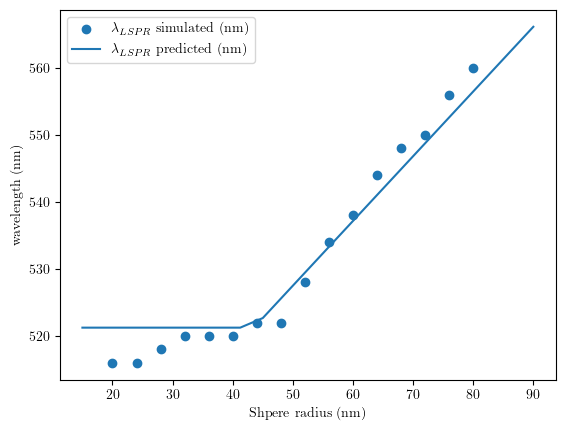

1/1 [==============================] - 0s 11ms/step
RMSE : 5.247314492881767 nm MAE : 5.247314453125 nm


In [39]:
MLP1EXT=modelMLP1.predict(ru)
plt.figure()
plt.scatter(feature,label,label='$\lambda_{LSPR}$ simulated (nm)')
plt.plot(ru,MLP1EXT,label='$\lambda_{LSPR}$ predicted (nm)')
plt.ylabel("wavelength (nm)")
plt.xlabel("Shpere radius (nm)")
plt.legend(loc='best')
plt.show()

mse_MLP1=modelMLP1.evaluate(feature_test,label_test)
rmse_MLP1=np.sqrt(mse_MLP1)
mae_MLP1=mean_absolute_error(label_test,modelMLP1.predict(feature_test.reshape(-1, 1)))
print('RMSE :',rmse_MLP1,'nm','MAE :',mae_MLP1,'nm')

### Learning process through epochs

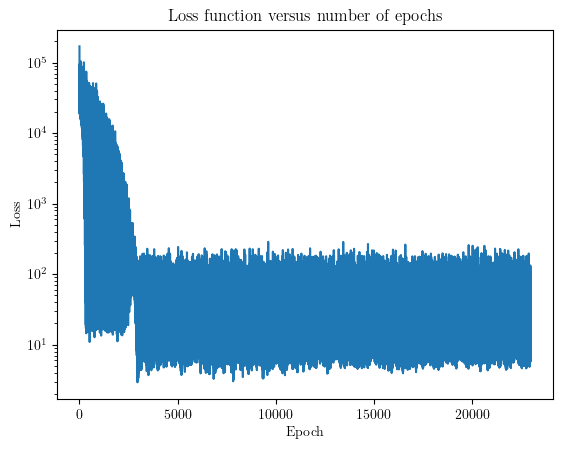

In [37]:
plt.semilogy(history.history['loss'])
plt.title('Loss function versus number of epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.show()


### Exponential scheduling

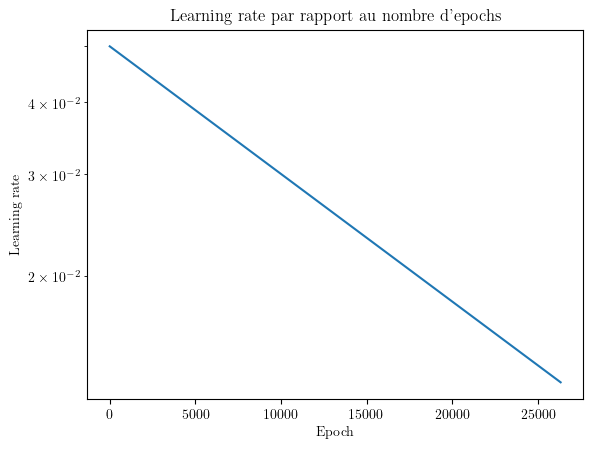

In [387]:
plt.semilogy(history.history["lr"])
plt.title('Learning rate with respect to the number of epochs')
plt.ylabel('Learning rate')
plt.xlabel('Epoch')

plt.show()

## More complex 3D set

Radius, refractive index and LSPR wavelength are studied.

### Read date

In [7]:
df2=pd.read_csv(r'/Users/eliasabboubi/Documents/PreLab/Programing/data_set_samples/spheresV5.csv')
df2

,radius,refractive index,Ext. maxima,wavelgth ext. max.,Sca. maxima,wavelgth sca. max.,Abs. maxima,wavelgth abs. max.,EF. maxima,wavelgth ef. max.
0,20.0,1.00,1.280937,516.0,0.043212,522.0,1.241792,514.0,1.018941,508.0
1,20.0,1.05,1.546413,520.0,0.057436,522.0,1.490329,518.0,1.026474,418.0
2,20.0,1.10,1.853285,520.0,0.075461,526.0,1.779933,520.0,1.033442,520.0
3,20.0,1.15,2.174521,520.0,0.098606,532.0,2.081695,520.0,1.039943,526.0
4,20.0,1.20,2.506169,522.0,0.128139,536.0,2.387432,522.0,1.046219,534.0
...,...,...,...,...,...,...,...,...,...,...
436,100.0,1.80,5.710937,696.0,4.361668,694.0,1.596705,614.0,2.843320,700.0
437,100.0,1.85,5.667940,708.0,4.351912,706.0,1.598348,624.0,2.774940,714.0
438,100.0,1.90,5.620068,760.0,4.315172,718.0,1.623708,666.0,2.685431,726.0
439,100.0,1.95,5.587177,776.0,4.280363,732.0,1.651854,676.0,2.602430,740.0


### Defining the differents set

This time a validation set is used to prevent overfitting, ensuring the model's ability to generalize to new data. It also aids in optimizing hyperparameters, allowing for improved model performance by tuning non-learnable parameters.

In [8]:
#Divide the data set into training, test sets and validation sets randomly where the features are the radius and the refractive index and the labels are the wavelength of the maxima of the extinction 
X=df2[['radius','refractive index']]
Y=df2[['wavelgth ext. max.']]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

### Multi input MLP

Parametring the model

In [394]:
def build_modelMLP2(hp):
    """
    This function builds a Sequential multi-layer perceptron (MLP) model with a variable number of hidden dense layers.
    The number of hidden layers, number of neurons in each hidden layer, and the learning rate for the model's optimizer are determined by a hyperparameter search space.

    Arguments:
    hp -- Keras Tuner hyperparameters class instance, used for defining the learning rate range, the number of neurons, and the number of hidden layers

    Returns:
    The constructed Sequential MLP model with defined optimizer, loss function, learning rate, neuron count, and hidden layer count.
    """
    
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=4, default=2)
    n_neurons = hp.Int("n_neurons", min_value=1, max_value=400)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e4,sampling="log")


    model=Sequential() 
    model.add(Normalization(input_shape=[2]))
    for _ in range(n_hidden):
        model.add(Dense(units=n_neurons,activation='swish',kernel_initializer="he_normal"))
    model.add(Dense(units=1))
    model.compile(optimizer=optimizers.Adam(learning_rate), loss='mean_squared_error',metrics=["accuracy"])
    return model

In [393]:
objective = kt.Objective("val_accuracy", direction="max")
#Use a bayesian tuner to find the best hyperparameters
bayesian_tuner = kt.BayesianOptimization(
    build_modelMLP2,
    objective=objective,
    max_trials=20,
    overwrite=True,
    directory="hpMLP2",
    project_name="my_bayesian_search",
)
bayesian_tuner.search(X_train, Y_train, epochs=1000,batch_size=4,validation_data=(X_val, Y_val),verbose=False)
bayesian_tuner.get_best_hyperparameters()[0].values

/Users/eliasabboubi/opt/miniconda3/envs/prelab-01/lib/python3.9/site-packages/keras_tuner/engine/metrics_tracking.py:107: RuntimeWarning: All-NaN axis encountered
  return np.nanmin(values) if self.direction == "min" else np.nanmax(values)
/Users/eliasabboubi/opt/miniconda3/envs/prelab-01/lib/python3.9/site-packages/keras_tuner/engine/metrics_tracking.py:107: RuntimeWarning: All-NaN axis encountered
  return np.nanmin(values) if self.direction == "min" else np.nanmax(values)
/Users/eliasabboubi/opt/miniconda3/envs/prelab-01/lib/python3.9/site-packages/keras_tuner/engine/metrics_tracking.py:107: RuntimeWarning: All-NaN axis encountered
  return np.nanmin(values) if self.direction == "min" else np.nanmax(values)
/Users/eliasabboubi/opt/miniconda3/envs/prelab-01/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and ca

INFO:tensorflow:Oracle triggered exit


{'n_hidden': 4, 'n_neurons': 298, 'learning_rate': 8.561509368773137}

### Building and Training the Model

To model the relationship between sphere radius, refractive index and LSPR wavelength, complex non-linear functions are required. To achieve this, a Multi-Layer Perceptron (MLP) model is used, with much more neurons and layers than the previous models. Also, a Swish activation function is used, which is a smooth, non-monotonic version of ReLU. The comparison between the two activation functions is shown below. Swish offer numerous advantages over ReLU, such as providing non-zero output for negative inputs, thus preserving information when the input is less than zero. It's a continuously differentiable function that is beneficial for optimization techniques that require the derivative of the activation function. Moreover, Swish effectively mitigates the "dead neurons" issue often observed with ReLU when the output is always zero for negative inputs. This characteristic leads to more active neurons contributing to model learning. Swish also presents a richer modeling capacity, capable of capturing more complex relationships in the data.

In [43]:
# Build the model with the optimal hyperparameters and train it on the data
modelMLP2=Sequential() 
modelMLP2.add(Normalization(input_shape=[2]))
for _ in range(2):
        modelMLP2.add(Dense(units=200,activation='swish',kernel_initializer=tf.keras.initializers.HeNormal(seed=seed_value)))
modelMLP2.add(Dense(units=1))
modelMLP2.summary()
modelMLP2.compile(optimizer=optimizers.Adam(5e-4), loss='mean_squared_error')

#train
early_stopping_cb = callbacks.EarlyStopping(monitor='val_loss',patience=4000,restore_best_weights=True)
history=modelMLP2.fit(X_train, Y_train, epochs=20000,validation_data=(X_val, Y_val),batch_size=4,verbose=False,callbacks=[early_stopping_cb])
early_stopping_cb.stopped_epoch


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_7 (Normalizat  (None, 2)                5         
 ion)                                                            
                                                                 
 dense_16 (Dense)            (None, 200)               600       
                                                                 
 dense_17 (Dense)            (None, 200)               40200     
                                                                 
 dense_18 (Dense)            (None, 1)                 201       
                                                                 
Total params: 41,006
Trainable params: 41,001
Non-trainable params: 5
_________________________________________________________________


16792

### Visualising the Model

In [44]:
ru2=np.linspace(15,110,121).reshape(-1, 1)
niu2=np.linspace(0.9,2.1,121).reshape(-1, 1)
RU, NIU = np.meshgrid(ru2,niu2)
MLP2EXT=modelMLP2.predict(np.c_[RU.ravel(), NIU.ravel()])
MLP2EXT=MLP2EXT.reshape(RU.shape)

#plot a 3D surface with the predicted values
fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'surface'}]])
fig.add_trace(go.Surface(x=RU, y=NIU, z=MLP2EXT,cmin=500,cmax=820))
fig.add_trace(go.Scatter3d(x=X_test['radius'], y=X_test['refractive index'], z=Y_test['wavelgth ext. max.'],mode='markers',marker=dict(size=3)))
fig.update_layout(scene=dict(xaxis_title='Radius (nm)', yaxis_title='Ref. index', zaxis_title='Wavelength (nm)'),height=600)
fig.update_scenes(zaxis=dict(range=[500, 820]))
fig.show()

mse_test=modelMLP2.evaluate(X_test, Y_test)
rmse=np.sqrt(mse_test)
mae=mean_absolute_error(Y_test,modelMLP2.predict(X_test))
print('RMSE :',rmse,'nm','MAE :',mae,'nm')


458/458 [==============================] - 0s 526us/step


3/3 [==============================] - 0s 2ms/step
RMSE : 12.449211395903069 nm MAE : 5.82464050978757 nm


### Learning process through epochs

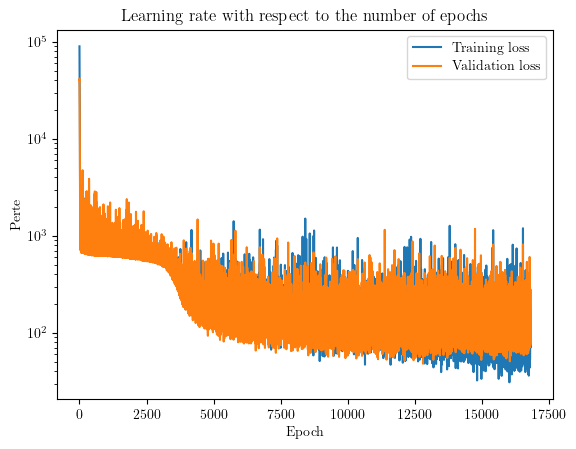

In [45]:
plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('Learning rate with respect to the number of epochs')
plt.ylabel('Perte')
plt.xlabel('Epoch')
plt.legend(['Training loss','Validation loss'])
plt.show()



### Comparison between ReLu and swish

The above code defines and visualizes two activation functions: Swish and ReLU. The Swish function, $x \times sigmoid(x)$, outputs a smooth curve that transitions from negative to positive values. It handles negative inputs by giving non-zero output. On the other hand, ReLU, or $max(0, x)$, simply outputs zero for all negative inputs and the input itself for all non-negative inputs. The Swish function is smoothly transitioning across the zero, while ReLU is abruptly cutting off at zero.

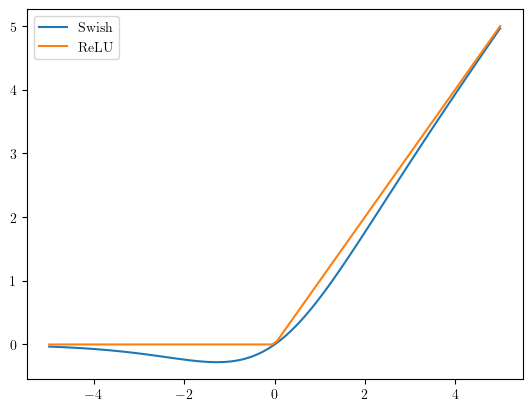

In [34]:
def swish(x):
    return x * tf.sigmoid(x)

def relu(x):
    return tf.nn.relu(x)

x = np.linspace(-5, 5, 100)

y_swish = swish(x)
y_relu = relu(x)

plt.plot(x, y_swish, label='Swish')
plt.plot(x, y_relu, label='ReLU')
plt.legend()

plt.show()
